In [146]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, TimeSeriesSplit
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.neural_network import MLPRegressor
from keras.models import Sequential
from keras.layers import Dense
from itertools import product
from numpy import unique

In [153]:
# Data Loading and Preprocessing
df = pd.read_csv('BeijingPM20100101_20151231.csv')
df = df.drop(columns=['PM_Dongsi', 'PM_Dongsihuan', 'PM_Nongzhanguan'])
df = df.dropna(subset=['PM_US Post'])
df = df.drop(columns=["Iprec"])
# Create a datetime index from year, month, day, hour columns
df['datetime'] = pd.to_datetime(df[['year','month','day','hour']])
df = df.set_index('datetime').sort_index()

# Precipitation Data Cleaning and Feature Engineering
df.loc[df['precipitation'] > 500, 'precipitation'] = np.nan
# Fill zero precipitation values·
df['precipitation'] = (
    df['precipitation']
    .interpolate("time")
    .rolling(3, min_periods=1)
    .mean()
)
# Binary feature for rain occurrence
df['is_rain'] = (df['precipitation'] > 0.1).astype(int)
# Log-transform precipitation to reduce skewness
df['precipitation_log'] = np.log1p(df['precipitation'])

# Smoothly fill missing values for other numerical columns within a limit of 6 time steps, 
# then forward-fill and backward-fill any remaining missing values
num_cols = ['DEWP', 'HUMI', 'PRES', 'TEMP', 'Iws']
num_cols = [c for c in num_cols if c in df.columns]
for col in num_cols:
    df[col] = df[col].interpolate(
        method='time',
        limit=6, 
        limit_direction='both'
    )
    df[col] = df[col].fillna(method='ffill').fillna(method='bfill')

# Strip whitespace and convert to lowercase for cbwd column
df['cbwd_original'] = df['cbwd']
# Clean version (lowercase + strip)
mask_not_na = df['cbwd'].notna()
df.loc[mask_not_na, 'cbwd'] = df.loc[mask_not_na, 'cbwd'].str.strip().str.lower()
# Fill missing values
df['cbwd'] = df['cbwd'].fillna(method='ffill').fillna(method='bfill')
# One-hot encode clean cbwd column
df = pd.get_dummies(df, columns=['cbwd'], drop_first=True)

# Feature engineering
df['hour'] = df.index.hour           # 0-23
df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24) # make a connection between 23 and 0
df['dayofweek'] = df.index.dayofweek # 0=Monday, 6=Sunday
df['month'] = df.index.month         # 1-12
# Binary feature for heating season (Nov-Mar)
df['heating_season'] = df['month'].isin([11, 12, 1, 2, 3]).astype(int)

dayofweek_orig = df['dayofweek']
season_orig = df['season']
# One-hot encode dayofweek and season
dummies = pd.get_dummies(df[['dayofweek', 'season']], columns=['dayofweek', 'season'], drop_first=True)
df = pd.concat([df, dummies], axis=1)
df['dayofweek'] = dayofweek_orig
df['season'] = season_orig

df = df.sort_index()
# Rolling mean features for PM_US Post
pm_shifted = df['PM_US Post'].shift(1)

df['pm_3h_mean']  = pm_shifted.rolling(window=3,   min_periods=1).mean()
df['pm_6h_mean']  = pm_shifted.rolling(window=6,   min_periods=1).mean()
df['pm_12h_mean'] = pm_shifted.rolling(window=12,  min_periods=1).mean()

# Define rolling window sizes in hours
HOURS_PER_DAY = 24
W_7D  = HOURS_PER_DAY * 7      # 168
W_30D = HOURS_PER_DAY * 30     # 720
W_90D = HOURS_PER_DAY * 90     # 2160

# Past 7 days
df['pm_7d_mean']   = pm_shifted.rolling(window=W_7D,  min_periods=HOURS_PER_DAY).mean()
df['pm_7d_median'] = pm_shifted.rolling(window=W_7D,  min_periods=HOURS_PER_DAY).median()
df['pm_7d_max']    = pm_shifted.rolling(window=W_7D,  min_periods=HOURS_PER_DAY).max()

# Past 30 days
df['pm_30d_mean'] = pm_shifted.rolling(window=W_30D, min_periods=HOURS_PER_DAY * 7).mean()
df['pm_30d_max']  = pm_shifted.rolling(window=W_30D, min_periods=HOURS_PER_DAY * 7).max()

# Past 90 days
df['pm_90d_mean'] = pm_shifted.rolling(window=W_90D, min_periods=HOURS_PER_DAY * 30).mean()
df['pm_90d_max']  = pm_shifted.rolling(window=W_90D, min_periods=HOURS_PER_DAY * 30).max()

# Week of year feature
week_iso = df.index.isocalendar()
week_series = getattr(week_iso, 'week', getattr(week_iso, 'week_number', None))
df['weekofyear'] = week_series.astype(int)

# Year-to-date features
# YTD mean
pm_ytd_mean = (
    df['PM_US Post']
      .groupby(df['year'])
      .expanding() 
      .mean()
      .reset_index(level=0, drop=True) 
      .shift(1)      )

# YTD max
pm_ytd_max = (
    df['PM_US Post']
      .groupby(df['year'])
      .expanding()
      .max()
      .reset_index(level=0, drop=True)
      .shift(1)
)

df['pm_ytd_mean'] = pm_ytd_mean
df['pm_ytd_max']  = pm_ytd_max

# Part of day feature
def assign_part_of_day(h):
    # 06:00–11:59 -> morning
    # 12:00–17:59 -> afternoon
    # 18:00–23:59 + 00:00–05:59 -> evening_night
    if 6 <= h <= 11:
        return 'morning'
    elif 12 <= h <= 17:
        return 'afternoon'
    else:
        return 'evening_night'

df['part_of_day'] = df['hour'].apply(assign_part_of_day)

part_dummies = pd.get_dummies(df['part_of_day'], prefix='part', drop_first=True)
df = pd.concat([df, part_dummies], axis=1)

show_rows = df.head(n=10)
print(df.columns.tolist())


['No', 'year', 'month', 'day', 'hour', 'season', 'PM_US Post', 'DEWP', 'HUMI', 'PRES', 'TEMP', 'Iws', 'precipitation', 'is_rain', 'precipitation_log', 'cbwd_original', 'cbwd_ne', 'cbwd_nw', 'cbwd_se', 'hour_sin', 'hour_cos', 'dayofweek', 'heating_season', 'dayofweek_1', 'dayofweek_2', 'dayofweek_3', 'dayofweek_4', 'dayofweek_5', 'dayofweek_6', 'season_2', 'season_3', 'season_4', 'pm_3h_mean', 'pm_6h_mean', 'pm_12h_mean', 'pm_7d_mean', 'pm_7d_median', 'pm_7d_max', 'pm_30d_mean', 'pm_30d_max', 'pm_90d_mean', 'pm_90d_max', 'weekofyear', 'pm_ytd_mean', 'pm_ytd_max', 'part_of_day', 'part_evening_night', 'part_morning']


/var/folders/ns/rqgd1xl11dlb66j9s7t53ssw0000gn/T/ipykernel_46699/4077292909.py:34: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[col] = df[col].fillna(method='ffill').fillna(method='bfill')
/var/folders/ns/rqgd1xl11dlb66j9s7t53ssw0000gn/T/ipykernel_46699/4077292909.py:34: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[col] = df[col].fillna(method='ffill').fillna(method='bfill')
/var/folders/ns/rqgd1xl11dlb66j9s7t53ssw0000gn/T/ipykernel_46699/4077292909.py:34: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[col] = df[col].fillna(method='ffill').fillna(method='bfill')
/var/folders/ns/rqgd1xl11dlb66j9s7t53ssw0000gn/T/ipykernel_46699/4077292909.py:34: FutureWarning: Series.fillna with 'method' is deprecated and will raise

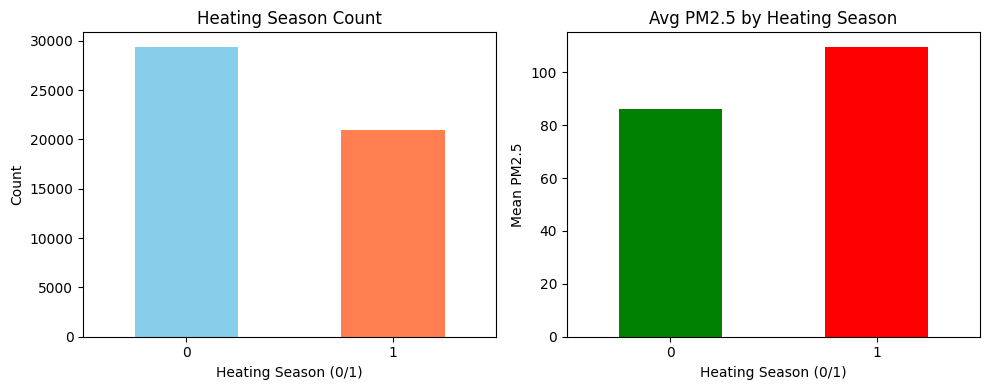

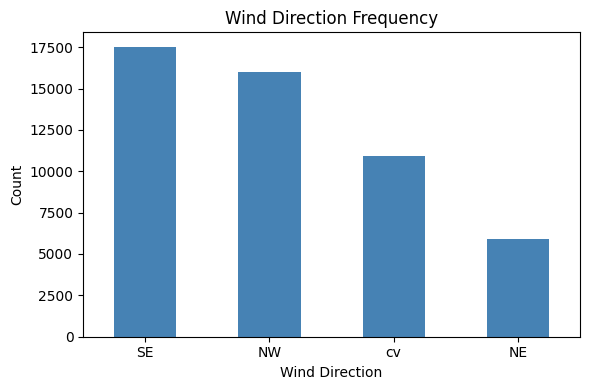

<Figure size 700x400 with 0 Axes>

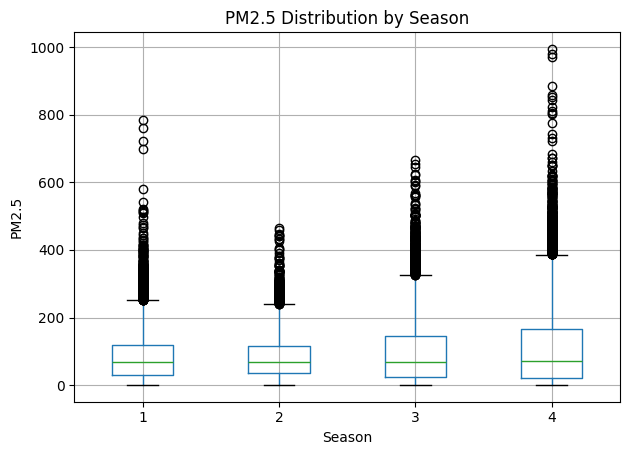

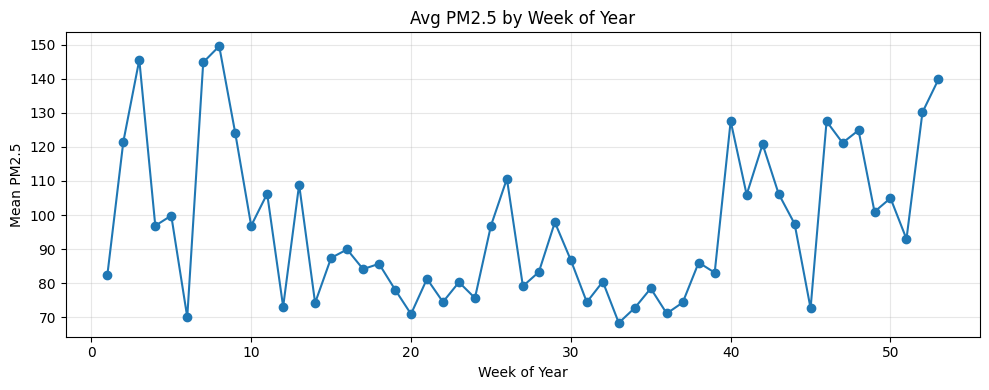

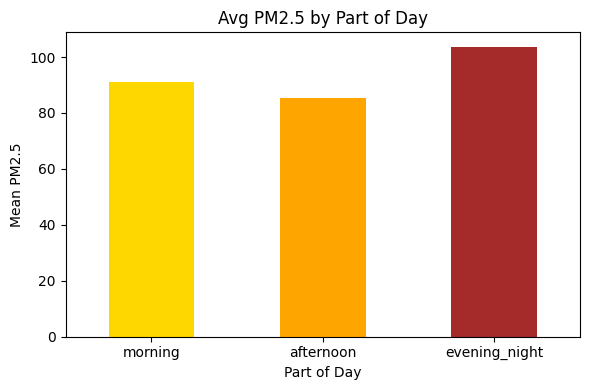

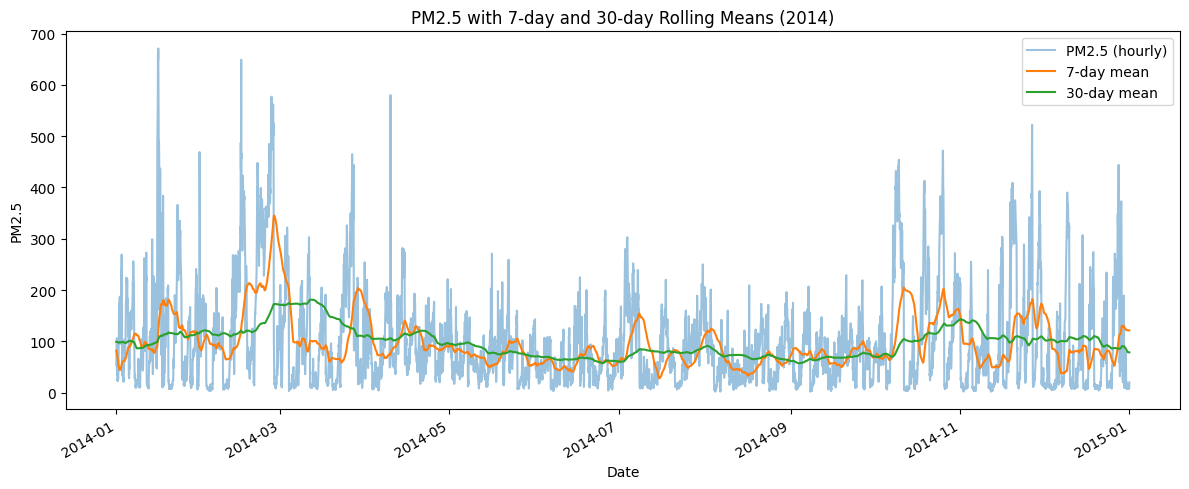

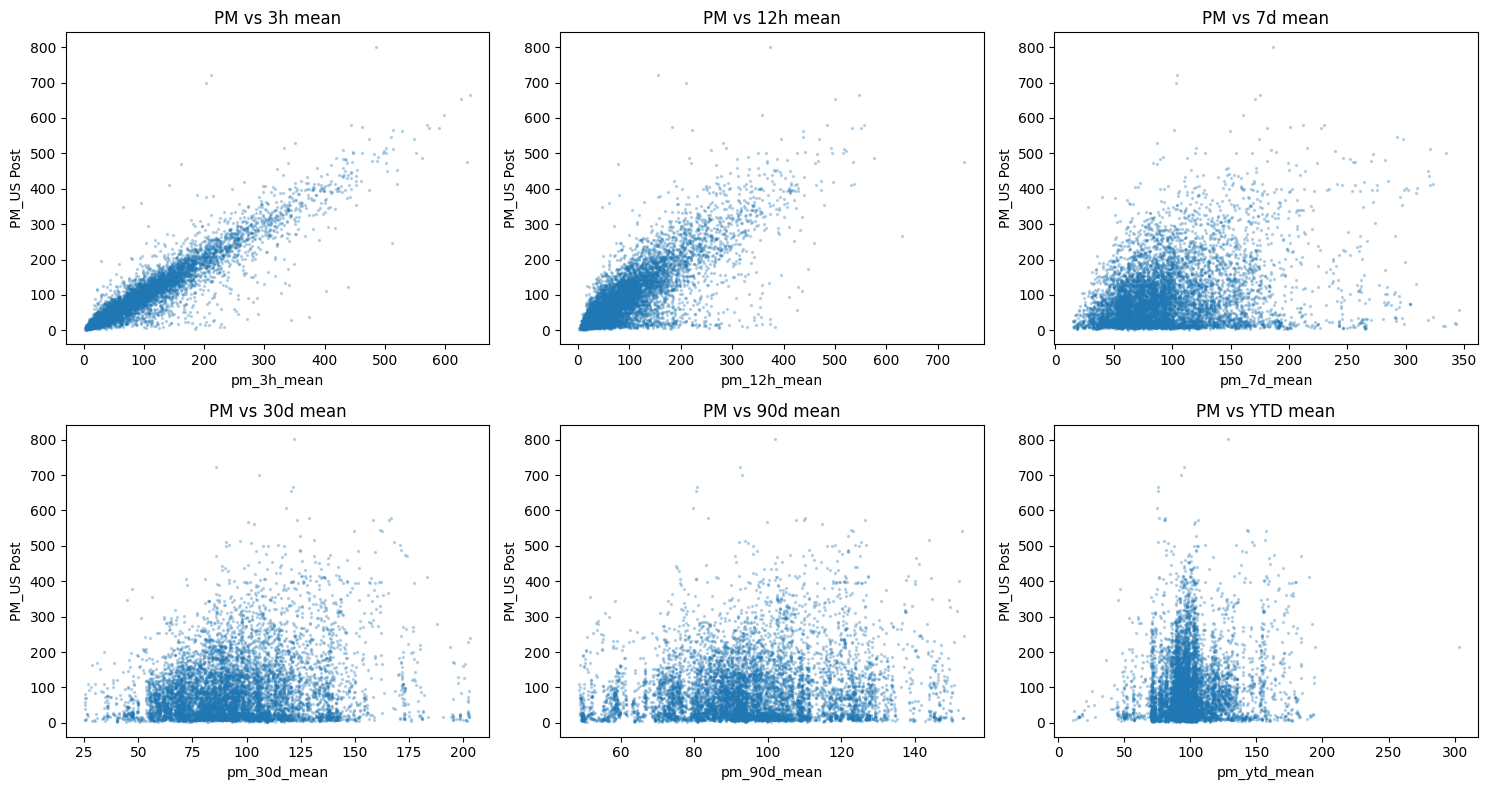

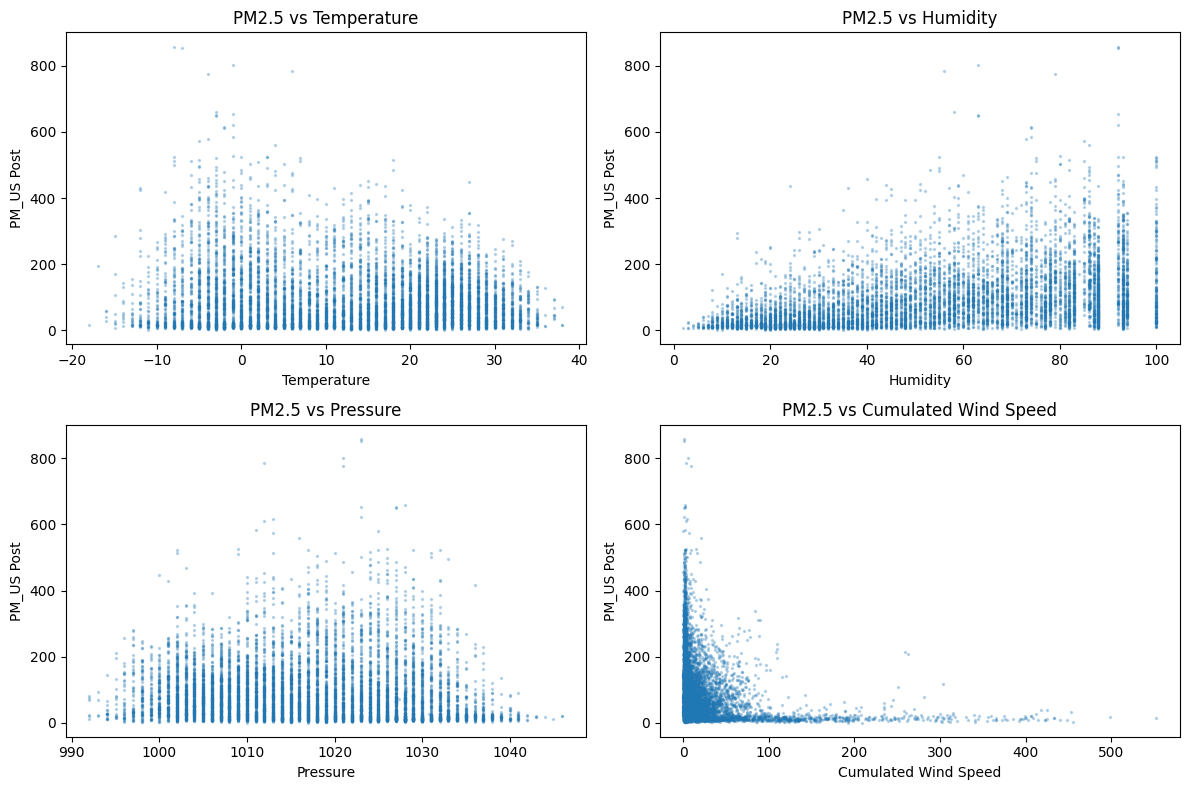

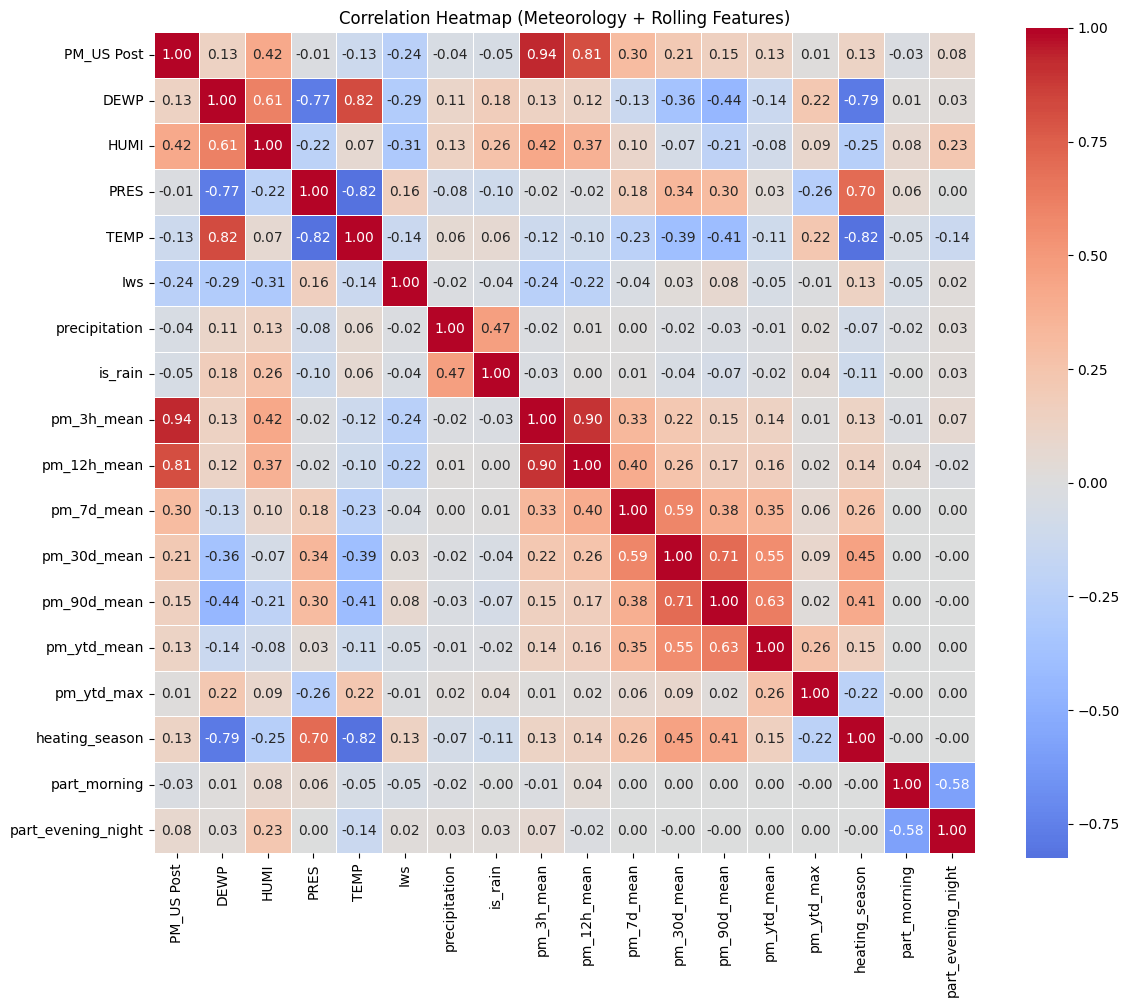

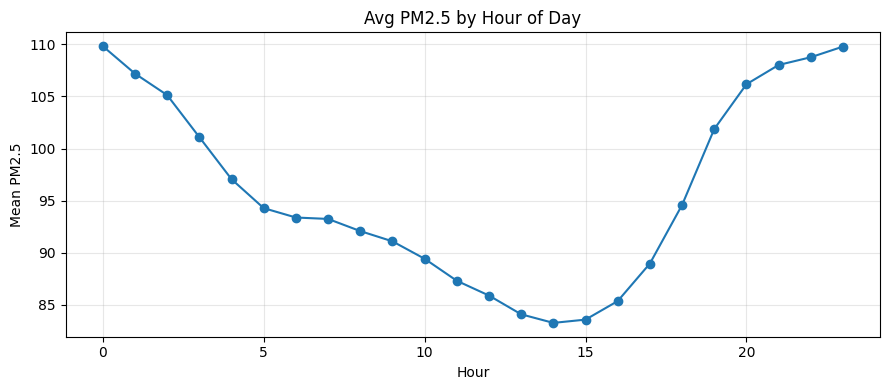

In [154]:
# Visualizations for Features
# Feature 1: Heating Season Distribution and PM2.5 difference
fig, axes = plt.subplots(1, 2, figsize=(10,4))

# Count distribution of heating vs non-heating
df['heating_season'].value_counts().sort_index().plot(
    kind='bar', ax=axes[0], color=['skyblue','coral']
)
axes[0].set_title("Heating Season Count")
axes[0].set_xlabel("Heating Season (0/1)")
axes[0].set_ylabel("Count")
axes[0].tick_params(axis='x', rotation=0)

# Avg PM2.5 for heating vs non-heating
df.groupby('heating_season')['PM_US Post'].mean().plot(
    kind='bar', ax=axes[1], color=['green','red']
)
axes[1].set_title("Avg PM2.5 by Heating Season")
axes[1].set_xlabel("Heating Season (0/1)")
axes[1].set_ylabel("Mean PM2.5")
axes[1].tick_params(axis='x', rotation=0)

plt.tight_layout()
plt.show()


# Feature 2: Wind Direction Distribution (original cbwd)
plt.figure(figsize=(6,4))
df['cbwd_original'].value_counts().plot(kind='bar', color='steelblue')
plt.title("Wind Direction Frequency")
plt.xlabel("Wind Direction")
plt.ylabel("Count")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


# Feature 3a: PM2.5 distribution across seasons
plt.figure(figsize=(7,4))
df.boxplot(column='PM_US Post', by='season')
plt.title("PM2.5 Distribution by Season")
plt.suptitle("")   # remove auto title
plt.xlabel("Season")
plt.ylabel("PM2.5")
plt.tight_layout()
plt.show()


# Feature 3b: PM2.5 trend across week-of-year
plt.figure(figsize=(10,4))
df.groupby('weekofyear')['PM_US Post'].mean().plot(marker='o')
plt.title("Avg PM2.5 by Week of Year")
plt.xlabel("Week of Year")
plt.ylabel("Mean PM2.5")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


# Feature 3c: PM2.5 by part of day
plt.figure(figsize=(6,4))
(df.groupby('part_of_day')['PM_US Post']
   .mean()
   .loc[['morning','afternoon','evening_night']]
   .plot(kind='bar', color=['gold','orange','brown'])
)
plt.title("Avg PM2.5 by Part of Day")
plt.xlabel("Part of Day")
plt.ylabel("Mean PM2.5")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


# Feature 4: PM2.5 with 7-day and 30-day rolling means (one-year view)
subset = df.loc['2014-01-01':'2014-12-31']

plt.figure(figsize=(12,5))
subset['PM_US Post'].plot(alpha=0.45, label='PM2.5 (hourly)')
subset['pm_7d_mean'].plot(label='7-day mean')
subset['pm_30d_mean'].plot(label='30-day mean')
plt.title("PM2.5 with 7-day and 30-day Rolling Means (2014)")
plt.xlabel("Date")
plt.ylabel("PM2.5")
plt.legend()
plt.tight_layout()
plt.show()


# Feature 5: Rolling feature relationships (scatter)
sample = df.sample(n=8000, random_state=42)

fig, axes = plt.subplots(2, 3, figsize=(15,8))
axes = axes.ravel()

scatter_pairs = [
    ('pm_3h_mean',  "PM vs 3h mean"),
    ('pm_12h_mean', "PM vs 12h mean"),
    ('pm_7d_mean',  "PM vs 7d mean"),
    ('pm_30d_mean', "PM vs 30d mean"),
    ('pm_90d_mean', "PM vs 90d mean"),
    ('pm_ytd_mean', "PM vs YTD mean")
]

for ax, (feat, title) in zip(axes, scatter_pairs):
    ax.scatter(sample[feat], sample['PM_US Post'], s=2, alpha=0.25)
    ax.set_xlabel(feat)
    ax.set_ylabel("PM_US Post")
    ax.set_title(title)

plt.tight_layout()
plt.show()


# Feature 6: PM2.5 vs meteorological variables
sample2 = df.sample(n=8000, random_state=7)

fig, axes = plt.subplots(2, 2, figsize=(12,8))
axes = axes.ravel()

met_pairs = [
    ('TEMP', "Temperature"),
    ('HUMI', "Humidity"),
    ('PRES', "Pressure"),
    ('Iws',  "Cumulated Wind Speed")
]

for ax, (feat, label) in zip(axes, met_pairs):
    ax.scatter(sample2[feat], sample2['PM_US Post'], s=2, alpha=0.25)
    ax.set_xlabel(label)
    ax.set_ylabel("PM_US Post")
    ax.set_title(f"PM2.5 vs {label}")

plt.tight_layout()
plt.show()


# Feature 7: Correlation heatmap for meteorology + rolling features
corr_cols = [
    'PM_US Post',
    'DEWP', 'HUMI', 'PRES', 'TEMP', 'Iws',
    'precipitation', 'is_rain',
    'pm_3h_mean', 'pm_12h_mean',
    'pm_7d_mean', 'pm_30d_mean', 'pm_90d_mean',
    'pm_ytd_mean', 'pm_ytd_max',
    'heating_season',
    'part_morning', 'part_evening_night'
]

corr_df = df[corr_cols].corr()

plt.figure(figsize=(12,10))
sns.heatmap(
    corr_df, annot=True, fmt=".2f",
    cmap="coolwarm", center=0,
    square=True, linewidths=0.5
)
plt.title("Correlation Heatmap (Meteorology + Rolling Features)")
plt.tight_layout()
plt.show()


# Feature 8: Hourly pattern of PM2.5
plt.figure(figsize=(9,4))
df.groupby('hour')['PM_US Post'].mean().plot(marker='o')
plt.title("Avg PM2.5 by Hour of Day")
plt.xlabel("Hour")
plt.ylabel("Mean PM2.5")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

Fold 1: R^2 = 0.880, RMSE = 33.97, MAE = 20.30
Fold 2: R^2 = 0.894, RMSE = 30.48, MAE = 19.11
Fold 3: R^2 = 0.888, RMSE = 28.78, MAE = 17.64
Fold 4: R^2 = 0.919, RMSE = 26.32, MAE = 16.49
Fold 5: R^2 = 0.908, RMSE = 26.34, MAE = 15.05

=== Linear Regression (TimeSeriesSplit CV) ===
Feature set      : Full
R^2 mean ± std   : 0.898 ± 0.014
RMSE mean ± std  : 29.18 ± 2.87
MAE mean ± std   : 17.72 ± 1.86


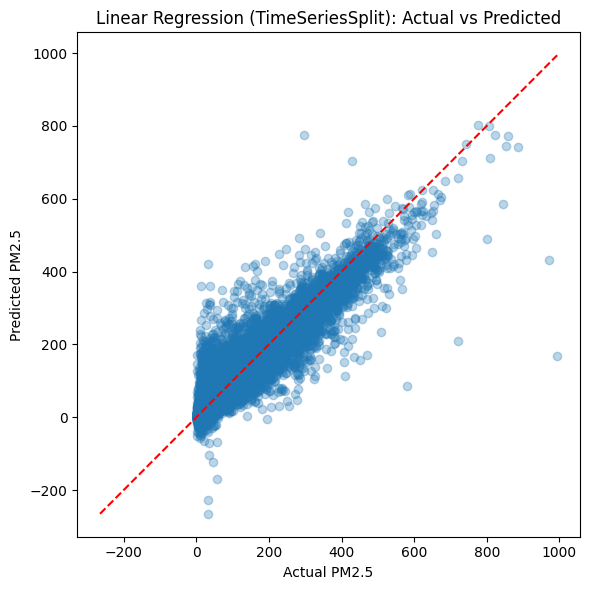

In [156]:
# Linear Regression with TimeSeriesSplit Cross-Validation
# Feature sets to compare
feature_sets = {
    # Baseline set: original meteorology + time + one-hot dummies
    'Baseline': [
        'DEWP', 'HUMI', 'PRES', 'TEMP', 'Iws', 'precipitation',
        'hour_sin', 'hour_cos', 'heating_season',
        'cbwd_ne', 'cbwd_nw', 'cbwd_se',
        'dayofweek_1', 'dayofweek_2', 'dayofweek_3', 
        'dayofweek_4', 'dayofweek_5', 'dayofweek_6',
        'season_2', 'season_3', 'season_4'
    ],
    
    # Full set: baseline + new precipitation, rolling, and aggregated features
    'Full': [
        'DEWP', 'HUMI', 'PRES', 'TEMP', 'Iws',
        'precipitation', 'is_rain', 'precipitation_log',
        'hour_sin', 'hour_cos', 'heating_season',
        'cbwd_ne', 'cbwd_nw', 'cbwd_se',
        'dayofweek_1', 'dayofweek_2', 'dayofweek_3', 
        'dayofweek_4', 'dayofweek_5', 'dayofweek_6',
        'season_2', 'season_3', 'season_4',
        # rolling and long-term PM features
        'pm_3h_mean', 'pm_6h_mean', 'pm_12h_mean',
        'pm_7d_mean', 'pm_7d_median', 'pm_7d_max',
        'pm_30d_mean', 'pm_30d_max',
        'pm_90d_mean', 'pm_90d_max',
        'pm_ytd_mean', 'pm_ytd_max',
        # additional time-based features
        'weekofyear',
        'part_morning', 'part_evening_night'
    ]
}

# Choose feature set
feature_key = 'Full'
X = df[feature_sets[feature_key]].copy()
y = df["PM_US Post"].copy()

mask = X.notna().all(axis=1)
X = X[mask]
y = y[mask]

# TimeSeriesSplit (no shuffling, respects temporal order)
tscv = TimeSeriesSplit(n_splits=5)

model = make_pipeline(StandardScaler(), LinearRegression())

r2_scores = []
rmse_scores = []
mae_scores = []

y_true_all = []
y_pred_all = []

fold = 0
for train_idx, test_idx in tscv.split(X):
    fold += 1
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)

    r2_scores.append(r2)
    rmse_scores.append(rmse)
    mae_scores.append(mae)

    y_true_all.extend(y_test.values)
    y_pred_all.extend(y_pred)

    print(f"Fold {fold}: R^2 = {r2:.3f}, RMSE = {rmse:.2f}, MAE = {mae:.2f}")

# Overall metrics
print("\n=== Linear Regression (TimeSeriesSplit CV) ===")
print(f"Feature set      : {feature_key}")
print(f"R^2 mean ± std   : {np.mean(r2_scores):.3f} ± {np.std(r2_scores):.3f}")
print(f"RMSE mean ± std  : {np.mean(rmse_scores):.2f} ± {np.std(rmse_scores):.2f}")
print(f"MAE mean ± std   : {np.mean(mae_scores):.2f} ± {np.std(mae_scores):.2f}")

# Actual vs Predicted plot
plt.figure(figsize=(6, 6))
plt.scatter(y_true_all, y_pred_all, alpha=0.3)
max_val = max(max(y_true_all), max(y_pred_all))
min_val = min(min(y_true_all), min(y_pred_all))
plt.plot([min_val, max_val], [min_val, max_val], "r--")
plt.xlabel("Actual PM2.5")
plt.ylabel("Predicted PM2.5")
plt.title(f"Linear Regression (TimeSeriesSplit): Actual vs Predicted")
plt.tight_layout()
plt.show()

In [161]:
# Polynomial Regression with TimeSeriesSplit Cross-Validation
poly_features = [
    'DEWP', 'HUMI', 'PRES', 'TEMP', 'Iws',
    'precipitation',
    'pm_3h_mean', 'pm_7d_mean', 'pm_30d_mean',
    'pm_ytd_mean'      # optional, you can drop this if you want fewer features
]

X_poly = X[poly_features].copy()

degree = 2

poly_model = Pipeline([
    ('scaler', StandardScaler()),
    ('poly', PolynomialFeatures(degree=degree, include_bias=False)),
    ('lr', LinearRegression())
])

tscv = TimeSeriesSplit(n_splits=5)

r2s, rmses, maes = [], [], []
y_true_poly, y_pred_poly = [], []

for train_idx, test_idx in tscv.split(X_poly):
    X_train, X_test = X_poly.iloc[train_idx], X_poly.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    poly_model.fit(X_train, y_train)
    y_pred = poly_model.predict(X_test)

    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)

    r2s.append(r2)
    rmses.append(rmse)
    maes.append(mae)
    y_true_poly.extend(y_test.values)
    y_pred_poly.extend(y_pred)

    print(f"Fold {fold}:  R^2 = {r2:.3f},  RMSE = {rmse:.2f},  MAE = {mae:.2f}")

print("\n=== Polynomial Regression Result (TimeSeriesSplit) ===")
print(f"Degree           : {degree}")
print(f"R^2 mean ± std   : {np.mean(r2s):.3f} ± {np.std(r2s):.3f}")
print(f"RMSE mean ± std  : {np.mean(rmses):.2f} ± {np.std(rmses):.2f}")
print(f"MAE mean ± std   : {np.mean(maes):.2f} ± {np.std(maes):.2f}")


Fold 3:  R^2 = 0.845,  RMSE = 38.51,  MAE = 21.77
Fold 3:  R^2 = 0.877,  RMSE = 32.83,  MAE = 19.57
Fold 3:  R^2 = 0.862,  RMSE = 31.97,  MAE = 19.05
Fold 3:  R^2 = 0.905,  RMSE = 28.46,  MAE = 17.51
Fold 3:  R^2 = 0.895,  RMSE = 28.13,  MAE = 15.42

=== Polynomial Regression Result (TimeSeriesSplit) ===
Degree           : 2
R^2 mean ± std   : 0.877 ± 0.022
RMSE mean ± std  : 31.98 ± 3.76
MAE mean ± std   : 18.67 ± 2.12


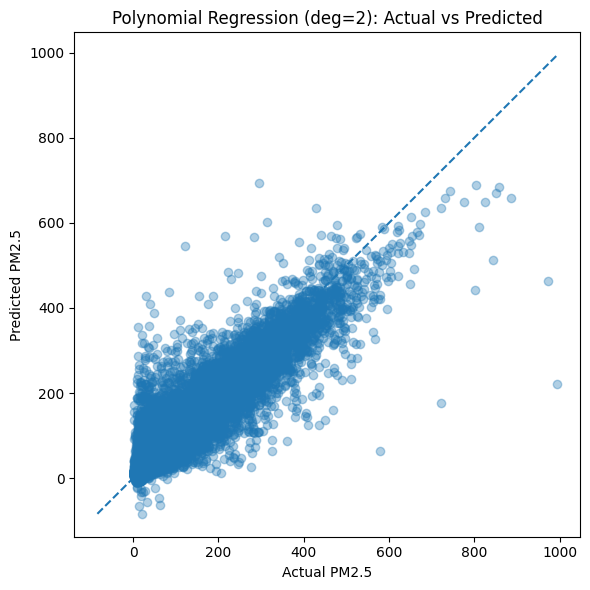

In [162]:
# Scatter plot of Actual vs Predicted PM2.5 for Polynomial Regression
y_true_poly_arr = np.array(y_true_poly)
y_pred_poly_arr = np.array(y_pred_poly)

plt.figure(figsize=(6, 6))
plt.scatter(y_true_poly_arr, y_pred_poly_arr, alpha=0.35)
min_val = min(y_true_poly_arr.min(), y_pred_poly_arr.min())
max_val = max(y_true_poly_arr.max(), y_pred_poly_arr.max())
plt.plot([min_val, max_val], [min_val, max_val], linestyle="--")
plt.xlabel("Actual PM2.5")
plt.ylabel("Predicted PM2.5")
plt.title("Polynomial Regression (deg=2): Actual vs Predicted")
plt.tight_layout()
plt.show()

In [163]:
# SVR Model with TimeSeriesSplit Cross-Validation

svm_model = make_pipeline(
    StandardScaler(),
    SVR(kernel='rbf', C=10, epsilon=5, gamma='scale')
)

tscv = TimeSeriesSplit(n_splits=5)

r2s, rmses, maes = [], [], []
y_true_svm, y_pred_svm = [], []

for fold, (train_idx, test_idx) in enumerate(tscv.split(X), 1):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    svm_model.fit(X_train, y_train)
    y_pred = svm_model.predict(X_test)

    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)

    r2s.append(r2)
    rmses.append(rmse)
    maes.append(mae)
    y_true_svm.extend(y_test.values)
    y_pred_svm.extend(y_pred)

    print(f"Fold {fold}: R^2 = {r2:.3f}, RMSE = {rmse:.2f}, MAE = {mae:.2f}")

print("\n=== SVM Regression (RBF kernel, TimeSeriesSplit) ===")
print(f"R^2 mean ± std   : {np.mean(r2s):.3f} ± {np.std(r2s):.3f}")
print(f"RMSE mean ± std  : {np.mean(rmses):.2f} ± {np.std(rmses):.2f}")
print(f"MAE mean ± std   : {np.mean(maes):.2f} ± {np.std(maes):.2f}")


Fold 1: R^2 = 0.786, RMSE = 45.25, MAE = 25.22
Fold 2: R^2 = 0.734, RMSE = 48.37, MAE = 26.12
Fold 3: R^2 = 0.868, RMSE = 31.27, MAE = 19.19
Fold 4: R^2 = 0.908, RMSE = 28.08, MAE = 17.28
Fold 5: R^2 = 0.870, RMSE = 31.37, MAE = 18.37

=== SVM Regression (RBF kernel, TimeSeriesSplit) ===
R^2 mean ± std   : 0.833 ± 0.064
RMSE mean ± std  : 36.87 ± 8.26
MAE mean ± std   : 21.24 ± 3.68


In [164]:
# Grid Search for Hyperparameter Tuning of SVR

param_grid = {
    "svr__C": [5, 10, 20, 50],
    "svr__gamma": ["scale", 0.1, 0.05, 0.01, 0.005],
    "svr__epsilon": [1, 3, 5, 8]
}

# TimeSeriesSplit for CV (same as in the SVM baseline above)
tscv = TimeSeriesSplit(n_splits=5)

svr_pipe = make_pipeline(
    StandardScaler(),
    SVR(kernel='rbf')
)

grid = GridSearchCV(
    estimator = svr_pipe,
    param_grid = param_grid,
    cv = tscv,
    scoring = "r2",
    n_jobs = -1,
    verbose = 1
)

grid.fit(X, y)

print("\n=== Best SVM Parameters (TimeSeriesSplit) ===")
print(grid.best_params_)
print("Best mean R^2 (CV):", grid.best_score_)

Fitting 5 folds for each of 80 candidates, totalling 400 fits


/Users/mazepeng/Desktop/CMSC 327/venv/lib/python3.13/site-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(



=== Best SVM Parameters (TimeSeriesSplit) ===
{'svr__C': 50, 'svr__epsilon': 3, 'svr__gamma': 0.005}
Best mean R^2 (CV): 0.8943069182566656


In [165]:
# Final Evaluation of Best SVM Model
best_svm = grid.best_estimator_
r2s, rmses, maes = [], [], []
y_true_best, y_pred_best = [], []

for fold, (train_idx, test_idx) in enumerate(tscv.split(X), 1):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    best_svm.fit(X_train, y_train)
    y_pred = best_svm.predict(X_test)

    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)

    r2s.append(r2)
    rmses.append(rmse)
    maes.append(mae)
    y_true_best.extend(y_test.values)
    y_pred_best.extend(y_pred)

    print(f"Fold {fold}: R^2 = {r2:.3f}, RMSE = {rmse:.2f}, MAE = {mae:.2f}")

print("\n=== Tuned SVR (RBF, TimeSeriesSplit) ===")
print(f"R^2 mean ± std   : {np.mean(r2s):.3f} ± {np.std(r2s):.3f}")
print(f"RMSE mean ± std  : {np.mean(rmses):.2f} ± {np.std(rmses):.2f}")
print(f"MAE mean ± std   : {np.mean(maes):.2f} ± {np.std(maes):.2f}")

Fold 1: R^2 = 0.877, RMSE = 34.39, MAE = 19.47
Fold 2: R^2 = 0.877, RMSE = 32.91, MAE = 19.26
Fold 3: R^2 = 0.889, RMSE = 28.68, MAE = 16.80
Fold 4: R^2 = 0.922, RMSE = 25.91, MAE = 15.60
Fold 5: R^2 = 0.908, RMSE = 26.44, MAE = 14.36

=== Tuned SVR (RBF, TimeSeriesSplit) ===
R^2 mean ± std   : 0.894 ± 0.018
RMSE mean ± std  : 29.66 ± 3.42
MAE mean ± std   : 17.10 ± 2.01


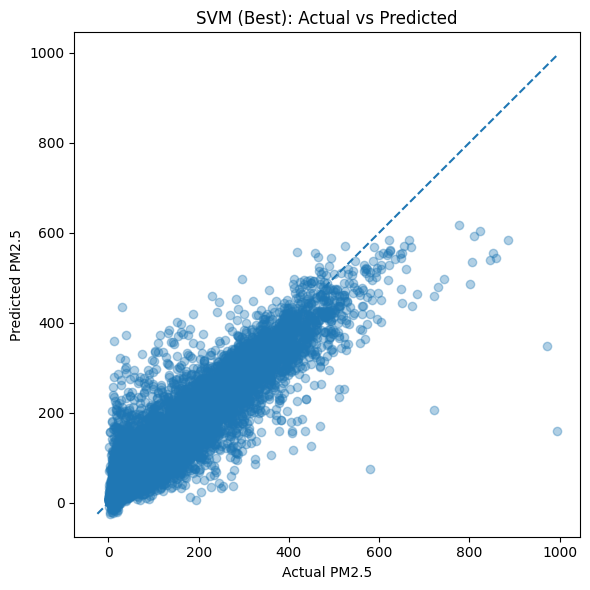

In [166]:
# Scatter plot of Actual vs Predicted PM2.5 for Best SVM Model
y_true_arr = np.array(y_true_best)
y_pred_arr = np.array(y_pred_best)

plt.figure(figsize=(6, 6))
plt.scatter(y_true_arr, y_pred_arr, alpha=0.35)
min_val = min(y_true_arr.min(), y_pred_arr.min())
max_val = max(y_true_arr.max(), y_pred_arr.max())
plt.plot([min_val, max_val], [min_val, max_val], linestyle="--")
plt.xlabel("Actual PM2.5")
plt.ylabel("Predicted PM2.5")
plt.title("SVM (Best): Actual vs Predicted")
plt.tight_layout()
plt.show()

In [167]:
# Random Forest Regression with TimeSeriesSplit Cross-Validation
rf = RandomForestRegressor(
    n_estimators=200,
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    random_state=42,
    n_jobs=-1
)

tscv = TimeSeriesSplit(n_splits=5)

r2s, rmses, maes = [], [], []
y_true_rf = []
y_pred_rf = []

for fold, (train_idx, test_idx) in enumerate(tscv.split(X), start=1):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    rf.fit(X_train, y_train)
    pred = rf.predict(X_test)
    
    y_true_rf.extend(y_test.values)
    y_pred_rf.extend(pred)

    r2  = r2_score(y_test, pred)
    rmse = np.sqrt(mean_squared_error(y_test, pred))
    mae  = mean_absolute_error(y_test, pred)

    r2s.append(r2)
    rmses.append(rmse)
    maes.append(mae)

    print(f"Fold {fold}: R^2={r2:.3f}, RMSE={rmse:.2f}, MAE={mae:.2f}")

print("\n=== Random Forest (TimeSeriesSplit) ===")
print(f"R^2   : {np.mean(r2s):.3f} ± {np.std(r2s):.3f}")
print(f"RMSE  : {np.mean(rmses):.2f}")
print(f"MAE   : {np.mean(maes):.2f}")

Fold 1: R^2=0.850, RMSE=37.94, MAE=21.55
Fold 2: R^2=0.838, RMSE=37.74, MAE=20.28
Fold 3: R^2=0.877, RMSE=30.16, MAE=18.36
Fold 4: R^2=0.918, RMSE=26.51, MAE=16.32
Fold 5: R^2=0.898, RMSE=27.81, MAE=15.97

=== Random Forest (TimeSeriesSplit) ===
R^2   : 0.876 ± 0.030
RMSE  : 32.03
MAE   : 18.49


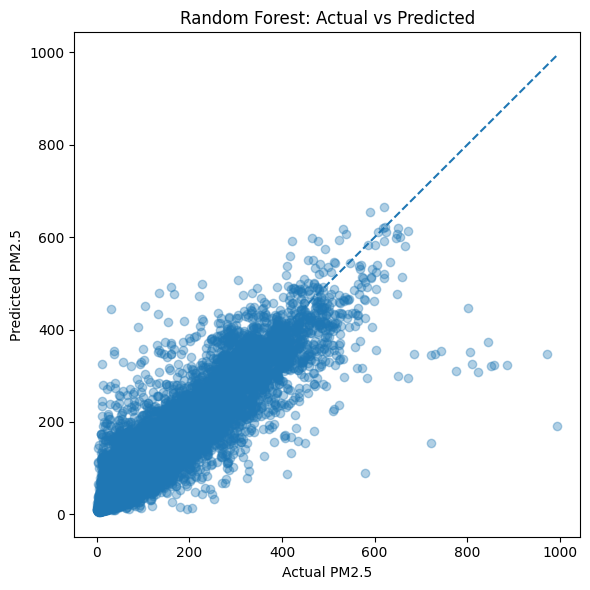

In [168]:
y_true_rf_arr = np.array(y_true_rf)
y_pred_rf_arr = np.array(y_pred_rf)

plt.figure(figsize=(6, 6))
plt.scatter(y_true_rf_arr, y_pred_rf_arr, alpha=0.35)
min_val = min(y_true_rf_arr.min(), y_pred_rf_arr.min())
max_val = max(y_true_rf_arr.max(), y_pred_rf_arr.max())
plt.plot([min_val, max_val], [min_val, max_val], linestyle="--")
plt.xlabel("Actual PM2.5")
plt.ylabel("Predicted PM2.5")
plt.title("Random Forest: Actual vs Predicted")
plt.tight_layout()
plt.show()

In [169]:
# XGBoost Regression with TimeSeriesSplit Cross-Validation
xgb = XGBRegressor(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_lambda=1.0,
    objective="reg:squarederror",
    random_state=42,
    n_jobs=-1
)

tscv = TimeSeriesSplit(n_splits=5)

r2s, rmses, maes = [], [], []

y_true_xgb = []
y_pred_xgb = []

for fold, (train_idx, test_idx) in enumerate(tscv.split(X), start=1):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    xgb.fit(X_train, y_train)
    pred = xgb.predict(X_test)

    y_true_xgb.extend(y_test.values)
    y_pred_xgb.extend(pred)

    r2  = r2_score(y_test, pred)
    rmse = np.sqrt(mean_squared_error(y_test, pred))
    mae  = mean_absolute_error(y_test, pred)

    r2s.append(r2)
    rmses.append(rmse)
    maes.append(mae)

    print(f"Fold {fold}: R^2={r2:.3f}, RMSE={rmse:.2f}, MAE={mae:.2f}")

print("\n=== XGBoost (TimeSeriesSplit) ===")
print(f"R^2   : {np.mean(r2s):.3f} ± {np.std(r2s):.3f}")
print(f"RMSE  : {np.mean(rmses):.2f}")
print(f"MAE   : {np.mean(maes):.2f}")

Fold 1: R^2=0.825, RMSE=41.00, MAE=23.13
Fold 2: R^2=0.839, RMSE=37.65, MAE=21.84
Fold 3: R^2=0.879, RMSE=29.89, MAE=18.41
Fold 4: R^2=0.920, RMSE=26.17, MAE=15.99
Fold 5: R^2=0.895, RMSE=28.12, MAE=16.79

=== XGBoost (TimeSeriesSplit) ===
R^2   : 0.872 ± 0.035
RMSE  : 32.57
MAE   : 19.23


In [171]:
# Grid Search for Hyperparameter Tuning of XGBoost
param_grid = {
    "n_estimators": [200, 300, 400, 600],
    "learning_rate": [0.03, 0.05, 0.1],
    "max_depth": [4, 6, 8],
    "subsample": [0.7, 0.8, 0.9],
    "colsample_bytree": [0.7, 0.8, 0.9],
}

# TimeSeriesSplit instead of shuffled KFold
tscv = TimeSeriesSplit(n_splits=5)

xgb_base = XGBRegressor(
    objective="reg:squarederror",
    reg_lambda=1.0,
    random_state=42,
    n_jobs=-1
)

grid = GridSearchCV(
    estimator=xgb_base,
    param_grid=param_grid,
    scoring="r2",
    cv=tscv,
    n_jobs=-1,
    verbose=1
)

grid.fit(X, y)

print("\n=== Best XGBoost Params (TimeSeriesSplit) ===")
print(grid.best_params_)
print(f"Best mean CV R^2: {grid.best_score_:.3f}")

Fitting 5 folds for each of 324 candidates, totalling 1620 fits


/Users/mazepeng/Desktop/CMSC 327/venv/lib/python3.13/site-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(



=== Best XGBoost Params (TimeSeriesSplit) ===
{'colsample_bytree': 0.8, 'learning_rate': 0.03, 'max_depth': 4, 'n_estimators': 200, 'subsample': 0.7}
Best mean CV R^2: 0.892


In [172]:
# Final Evaluation of Best XGBoost Model (TimeSeriesSplit)
best_xgb = grid.best_estimator_

tscv = TimeSeriesSplit(n_splits=5)

r2s, rmses, maes = [], [], []
y_true_xgb = []
y_pred_xgb = []

for fold, (train_idx, test_idx) in enumerate(tscv.split(X), start=1):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    best_xgb.fit(X_train, y_train)
    pred = best_xgb.predict(X_test)
    
    y_true_xgb.extend(y_test.values)
    y_pred_xgb.extend(pred)

    r2  = r2_score(y_test, pred)
    rmse = np.sqrt(mean_squared_error(y_test, pred))
    mae  = mean_absolute_error(y_test, pred)

    r2s.append(r2)
    rmses.append(rmse)
    maes.append(mae)

    print(f"Fold {fold}: R^2={r2:.3f}, RMSE={rmse:.2f}, MAE={mae:.2f}")

print("\n=== FINAL XGBoost (Tuned, TimeSeriesSplit) ===")
print(f"R^2   : {np.mean(r2s):.3f} ± {np.std(r2s):.3f}")
print(f"RMSE  : {np.mean(rmses):.2f}")
print(f"MAE   : {np.mean(maes):.2f}")

Fold 1: R^2=0.874, RMSE=34.77, MAE=19.61
Fold 2: R^2=0.877, RMSE=32.95, MAE=18.19
Fold 3: R^2=0.883, RMSE=29.48, MAE=17.46
Fold 4: R^2=0.920, RMSE=26.08, MAE=16.13
Fold 5: R^2=0.905, RMSE=26.76, MAE=14.64

=== FINAL XGBoost (Tuned, TimeSeriesSplit) ===
R^2   : 0.892 ± 0.018
RMSE  : 30.01
MAE   : 17.20


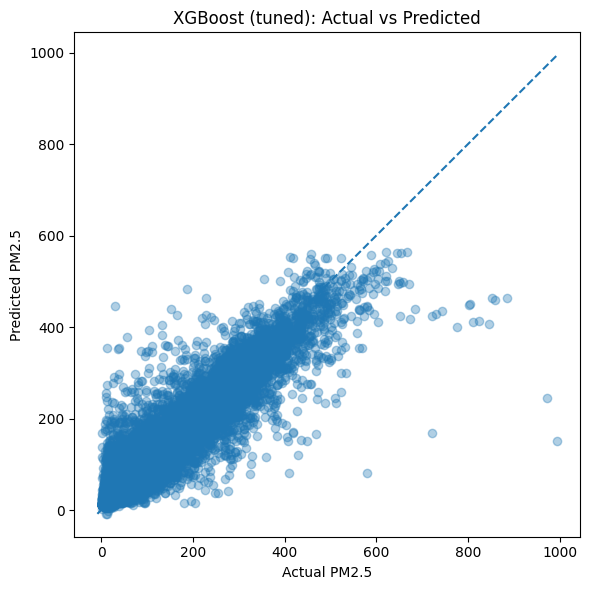

In [173]:
y_true_xgb_arr = np.array(y_true_xgb)
y_pred_xgb_arr = np.array(y_pred_xgb)

plt.figure(figsize=(6, 6))
plt.scatter(y_true_xgb_arr, y_pred_xgb_arr, alpha=0.35)
min_val = min(y_true_xgb_arr.min(), y_pred_xgb_arr.min())
max_val = max(y_true_xgb_arr.max(), y_pred_xgb_arr.max())
plt.plot([min_val, max_val], [min_val, max_val], linestyle="--")
plt.xlabel("Actual PM2.5")
plt.ylabel("Predicted PM2.5")
plt.title("XGBoost (tuned): Actual vs Predicted")
plt.tight_layout()
plt.show()

In [174]:
# MLP Regressor with TimeSeriesSplit Cross-Validation
mlp = make_pipeline(
    StandardScaler(),
    MLPRegressor(
        hidden_layer_sizes=(64, 32),
        activation="relu",
        solver="adam",
        alpha=1e-4,
        learning_rate="adaptive",
        max_iter=300,
        random_state=42,
        early_stopping=True,
        validation_fraction=0.1,
        n_iter_no_change=10
    )
)

tscv = TimeSeriesSplit(n_splits=5)

r2s, rmses, maes = [], [], []
y_true_mlp = []
y_pred_mlp = []

for fold, (train_idx, test_idx) in enumerate(tscv.split(X), start=1):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    mlp.fit(X_train, y_train)
    pred = mlp.predict(X_test)
    
    y_true_mlp.extend(y_test.values)
    y_pred_mlp.extend(pred)

    r2  = r2_score(y_test, pred)
    rmse = np.sqrt(mean_squared_error(y_test, pred))
    mae  = mean_absolute_error(y_test, pred)

    r2s.append(r2)
    rmses.append(rmse)
    maes.append(mae)

    print(f"Fold {fold}: R^2={r2:.3f}, RMSE={rmse:.2f}, MAE={mae:.2f}")

print("\n=== MLP (TimeSeriesSplit) ===")
print(f"R^2   : {np.mean(r2s):.3f} ± {np.std(r2s):.3f}")
print(f"RMSE  : {np.mean(rmses):.2f}")
print(f"MAE   : {np.mean(maes):.2f}")

Fold 1: R^2=0.848, RMSE=38.18, MAE=24.43
Fold 2: R^2=0.876, RMSE=33.02, MAE=22.33
Fold 3: R^2=0.878, RMSE=30.08, MAE=19.16
Fold 4: R^2=0.917, RMSE=26.60, MAE=17.14
Fold 5: R^2=0.910, RMSE=26.13, MAE=15.35

=== MLP (TimeSeriesSplit) ===
R^2   : 0.886 ± 0.025
RMSE  : 30.80
MAE   : 19.68


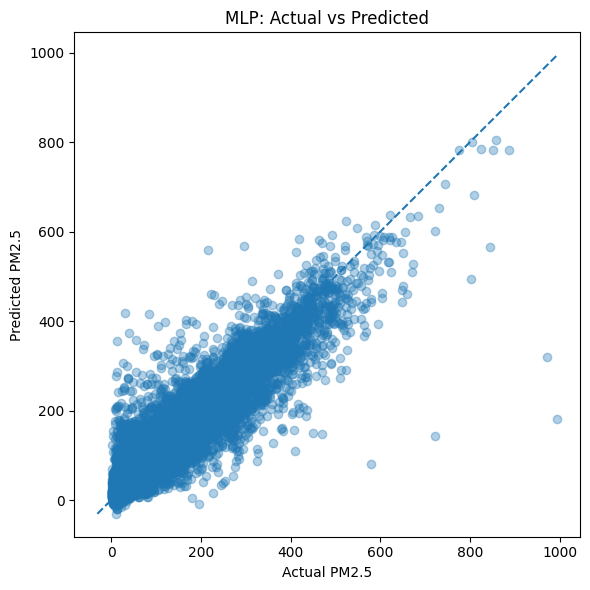

In [175]:
y_true_mlp_arr = np.array(y_true_mlp)
y_pred_mlp_arr = np.array(y_pred_mlp)

plt.figure(figsize=(6, 6))
plt.scatter(y_true_mlp_arr, y_pred_mlp_arr, alpha=0.35)
min_val = min(y_true_mlp_arr.min(), y_pred_mlp_arr.min())
max_val = max(y_true_mlp_arr.max(), y_pred_mlp_arr.max())
plt.plot([min_val, max_val], [min_val, max_val], linestyle="--")
plt.xlabel("Actual PM2.5")
plt.ylabel("Predicted PM2.5")
plt.title("MLP: Actual vs Predicted")
plt.tight_layout()
plt.show()